In [1]:
import spacy
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [13]:
emotions = ['love','anger','fear','surprise','joy','sadness']

df_love = pd.read_csv('C:/users/kecco/Documenti/Github/DataMining-EmotionDetection/data/Processed/Dataset/StackOverflow/love.csv',sep=';',encoding='iso-8859-1')

df_anger = pd.read_csv('C:/users/kecco/Documenti/Github/DataMining-EmotionDetection/data/Processed/Dataset/StackOverflow/anger.csv',sep=';',encoding='iso-8859-1')

df_fear = pd.read_csv('C:/users/kecco/Documenti/Github/DataMining-EmotionDetection/data/Processed/Dataset/StackOverflow/fear.csv',sep=';',encoding='iso-8859-1')

df_surprise = pd.read_csv('C:/users/kecco/Documenti/Github/DataMining-EmotionDetection/data/Processed/Dataset/StackOverflow/surprise.csv',sep=';',encoding='iso-8859-1')

df_joy = pd.read_csv('C:/users/kecco/Documenti/Github/DataMining-EmotionDetection/data/Processed/Dataset/StackOverflow/joy.csv',sep=';',encoding='iso-8859-1')

df_sadness = pd.read_csv('C:/users/kecco/Documenti/Github/DataMining-EmotionDetection/data/Processed/Dataset/StackOverflow/sadness.csv',sep=';',encoding='iso-8859-1')

df_list = [df_love,df_anger,df_fear,df_surprise,df_joy,df_sadness]

In [4]:
#!pip install spacy-transformers
#!python -m spacy download en_core_web_trf

nlp = spacy.load("en_core_web_sm") # en_core_web_trf

sentences = df_anger['Text']
vectorized = []

for i,sentence in enumerate(sentences):
    print(i)
    doc = nlp(sentence)
    v = doc.vector
    vectorized.append(v)


4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290


In each dataframe we have same set of sentences, so x will be the same

In [11]:
x = vectorized

def set_labels(df,i):
    y = df['label']
    y = y.fillna(0)
    y = y.map({emotions[i].upper(): 1, 0: 0}).astype(int)
    return y

In [16]:
from imblearn.over_sampling import SMOTE

def split_balancing(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)
    sm = SMOTE(sampling_strategy=1, random_state=10)
    x_train = np.array(x_train)
    x_smote, y_smote = sm.fit_resample(x_train, y_train)
    return x_smote,y_smote, x_test, y_test

In [7]:
from sklearn.model_selection import GridSearchCV

def train_model(model,param_grid,x_smote,y_smote):
    scoring = ['f1', 'roc_auc']
    #param_grid = {'C': [0.01, 0.05, 0.10, 0.20, 0.50, 1, 2, 4, 8]}

    gs = GridSearchCV(model, param_grid, scoring=scoring,
                          refit='roc_auc', cv=10, verbose=2, n_jobs=-1,
                          return_train_score=True)

    gs.fit(x_smote, y_smote)

    # print best parameter after tuning
    print("\nBest parameter GridSearchCV: ")
    print(gs.best_params_)
    return gs

In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, f1_score
import scikitplot as skplt
import matplotlib.pyplot as plt


def evaluation(gs,x_test,y_test):
    grid_predictions = gs.predict(x_test)

    # print classification report
    print(classification_report(y_test, grid_predictions))
    rfc = gs.best_estimator_
    print("\nC parameter's value used: ")
    print(rfc)
    print("\nAUC: ")
    print(roc_auc_score(y_test, grid_predictions))
    print("\nF1: ")
    print(f1_score(y_test, grid_predictions))
    skplt.metrics.plot_confusion_matrix(grid_predictions, y_test)
    plt.show()



SVM

Fitting 10 folds for each of 3 candidates, totalling 30 fits

Best parameter GridSearchCV: 
{'C': 0.05}
              precision    recall  f1-score   support

           0       0.94      0.62      0.75       862
           1       0.16      0.62      0.25        98

    accuracy                           0.62       960
   macro avg       0.55      0.62      0.50       960
weighted avg       0.86      0.62      0.70       960


C parameter's value used: 
LinearSVC(C=0.05, max_iter=10000)

AUC: 
0.6232894549931342

F1: 
0.2525879917184265


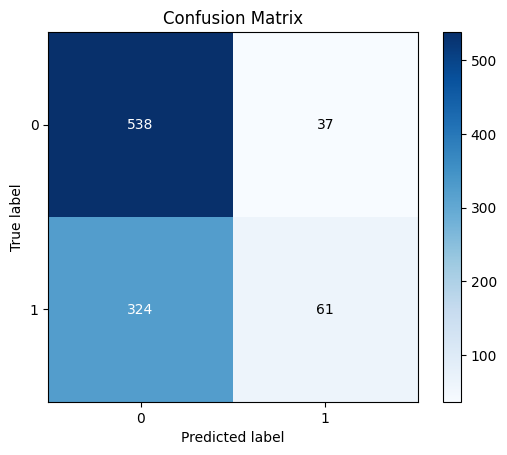

In [17]:
from sklearn.svm import LinearSVC

model = LinearSVC(max_iter=10000)# class_weight='balanced'
param_grid = {'C': [0.05,1,8]}
df = df_joy
df_i = 4
y = set_labels(df,df_i)
x_smote,y_smote,x_test,y_test = split_balancing(x,y)
tuned_model = train_model(model,param_grid,x_smote,y_smote)
evaluation(tuned_model,x_test,y_test)

RANDOM FOREST

Fitting 10 folds for each of 3 candidates, totalling 30 fits

Best parameter GridSearchCV: 
{'n_estimators': 1000}
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       862
           1       0.27      0.15      0.19        98

    accuracy                           0.87       960
   macro avg       0.59      0.55      0.56       960
weighted avg       0.84      0.87      0.85       960


C parameter's value used: 
RandomForestClassifier(n_estimators=1000)

AUC: 
0.5527487096926937

F1: 
0.19480519480519481


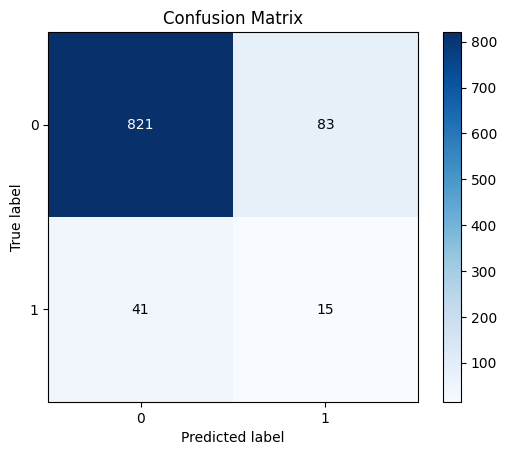

In [21]:
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier()# class_weight='balanced'
param_grid = {'n_estimators': [10,100,1000]}

df = df_joy
df_i = 4
y = set_labels(df,df_i)
x_smote,y_smote,x_test,y_test = split_balancing(x,y)
tuned_model = train_model(model,param_grid,x_smote,y_smote)
evaluation(tuned_model,x_test,y_test)

KNN

Fitting 10 folds for each of 2 candidates, totalling 20 fits

Best parameter GridSearchCV: 
{'n_neighbors': 5}
              precision    recall  f1-score   support

           0       0.94      0.40      0.56       862
           1       0.13      0.77      0.22        98

    accuracy                           0.44       960
   macro avg       0.53      0.58      0.39       960
weighted avg       0.85      0.44      0.52       960


C parameter's value used: 
KNeighborsClassifier()

AUC: 
0.58218902410152

F1: 
0.21707670043415342


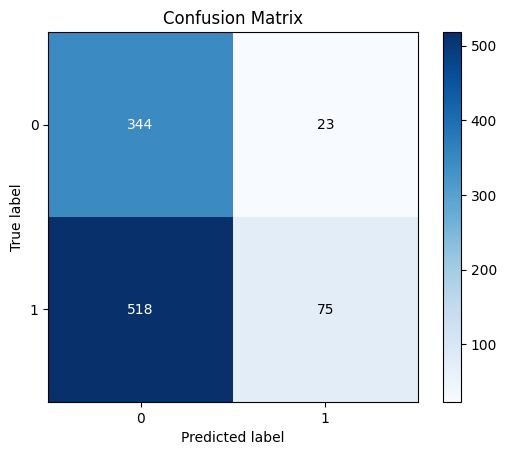

In [19]:
from sklearn.neighbors import  KNeighborsClassifier

model=KNeighborsClassifier(algorithm='auto')
param_grid = {'n_neighbors': [3,5]}

df = df_joy
df_i = 4
y = set_labels(df,df_i)
x_smote,y_smote,x_test,y_test = split_balancing(x,y)
tuned_model = train_model(model,param_grid,x_smote,y_smote)
evaluation(tuned_model,x_test,y_test)

DUMMY

Fitting 10 folds for each of 3 candidates, totalling 30 fits

Best parameter GridSearchCV: 
{'strategy': 'most_frequent'}
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       862
           1       0.00      0.00      0.00        98

    accuracy                           0.90       960
   macro avg       0.45      0.50      0.47       960
weighted avg       0.81      0.90      0.85       960


C parameter's value used: 
DummyClassifier(strategy='most_frequent')

AUC: 
0.5

F1: 
0.0


C:\Users\kecco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kecco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kecco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

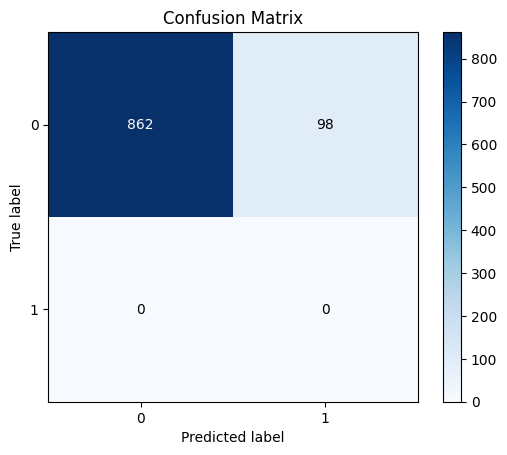

In [20]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier()
param_grid={'strategy': ['most_frequent','stratified','prior']}

df = df_joy
df_i = 4
y = set_labels(df,df_i)
x_smote,y_smote,x_test,y_test = split_balancing(x,y)
tuned_model = train_model(model,param_grid,x_smote,y_smote)
evaluation(tuned_model,x_test,y_test)

In [29]:
df_anger_j = pd.read_csv('C:/users/kecco/Documenti/Github/DataMining-EmotionDetection/data/Processed/Dataset/Jira/anger.csv',sep=';',encoding='iso-8859-1')

print(df_anger_j)

                                               ï»¿text  label
0                         guys... this is so stupid...  ANGER
1    I lost the whole morning cause HBase's RegionS...  ANGER
2    {quote}You are messing down deep below hbase i...  ANGER
3    And I think if we're going to do a sweep up of...  ANGER
4    @idiot Yeah, I was on that idiot-path for a go...  ANGER
..                                                 ...    ...
969  You don't see '>' replaced because that's not ...    NaN
970                                  Making a blocker.    NaN
971                 I've reverted this for the moment.    NaN
972           and at the moment we dont have that yet.    NaN
973  Maybe we're stuck with it until log4j fixes it...    NaN

[974 rows x 2 columns]


In [31]:
df_final = pd.concat([df_anger,df_anger_j])

print(df_final)

                                                  Text label
0    SVG transform on text attribute works excellen...   NaN
1    Excellent! This is exactly what I needed. Thanks!   NaN
2    Have added a modern solution as of May 2014 in...   NaN
3    Have you tried removing 'preload' attribute? (...   NaN
4    A smarter, entirely C++-way of doing what you ...   NaN
..                                                 ...   ...
969  You don't see '>' replaced because that's not ...   NaN
970                                  Making a blocker.   NaN
971                 I've reverted this for the moment.   NaN
972           and at the moment we dont have that yet.   NaN
973  Maybe we're stuck with it until log4j fixes it...   NaN

[5774 rows x 2 columns]


In [30]:
df_anger_j.columns.values[0] = "Text"

print(df_anger_j)

                                                  Text  label
0                         guys... this is so stupid...  ANGER
1    I lost the whole morning cause HBase's RegionS...  ANGER
2    {quote}You are messing down deep below hbase i...  ANGER
3    And I think if we're going to do a sweep up of...  ANGER
4    @idiot Yeah, I was on that idiot-path for a go...  ANGER
..                                                 ...    ...
969  You don't see '>' replaced because that's not ...    NaN
970                                  Making a blocker.    NaN
971                 I've reverted this for the moment.    NaN
972           and at the moment we dont have that yet.    NaN
973  Maybe we're stuck with it until log4j fixes it...    NaN

[974 rows x 2 columns]


In [32]:
sentences = df_final['Text']
vectorized = []

for i,sentence in enumerate(sentences):
    print(i)
    doc = nlp(sentence)
    v = doc.vector
    vectorized.append(v)

x = vectorized

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Fitting 10 folds for each of 3 candidates, totalling 30 fits

Best parameter GridSearchCV: 
{'C': 8}
              precision    recall  f1-score   support

           0       0.87      0.65      0.74       914
           1       0.32      0.63      0.42       241

    accuracy                           0.64      1155
   macro avg       0.59      0.64      0.58      1155
weighted avg       0.75      0.64      0.67      1155


C parameter's value used: 
LinearSVC(C=8, max_iter=10000)

AUC: 
0.6360351198961294

F1: 
0.42178770949720673


C:\Users\kecco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


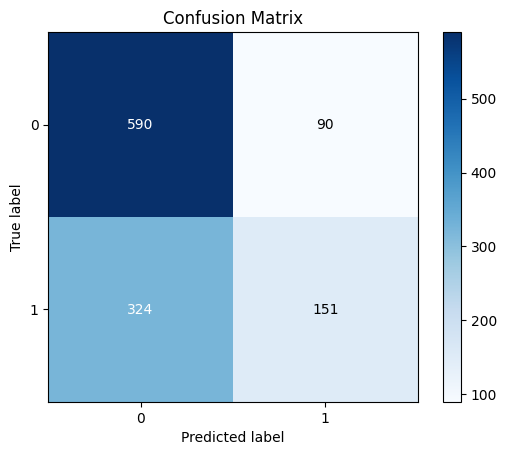

In [33]:
from sklearn.svm import LinearSVC

model = LinearSVC(max_iter=10000)# class_weight='balanced'
param_grid = {'C': [0.05,1,8]}
df = df_final
df_i = 1
y = set_labels(df_final,df_i)
x_smote,y_smote,x_test,y_test = split_balancing(x,y)
tuned_model = train_model(model,param_grid,x_smote,y_smote)
evaluation(tuned_model,x_test,y_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits

Best parameter GridSearchCV: 
{'n_neighbors': 5}
              precision    recall  f1-score   support

           0       0.88      0.34      0.49       914
           1       0.25      0.82      0.38       241

    accuracy                           0.44      1155
   macro avg       0.56      0.58      0.43      1155
weighted avg       0.75      0.44      0.46      1155


C parameter's value used: 
KNeighborsClassifier()

AUC: 
0.5787314889637452

F1: 
0.37858508604206503


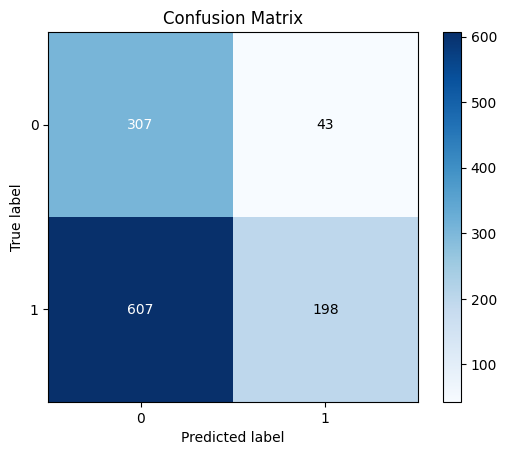

In [34]:
from sklearn.neighbors import  KNeighborsClassifier

model=KNeighborsClassifier(algorithm='auto')
param_grid = {'n_neighbors': [3,5]}

df = df_final
df_i = 1
y = set_labels(df_final, df_i)
x_smote, y_smote, x_test, y_test = split_balancing(x, y)
tuned_model = train_model(model, param_grid, x_smote, y_smote)
evaluation(tuned_model, x_test, y_test)